In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

#to prevent Tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
df= pd.read_csv("/content/TSLA.csv", sep=",")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
def check_df(dataframe, head=5):
  print("**********Shape**********")
  print(dataframe.shape)
  print("**********Types**********")
  print(dataframe.dtypes)
  print("**********Head***********")
  print(dataframe.head(head))
  print("**********Tail***********")
  print(dataframe.tail(head))
  print("***********NA************")
  print(dataframe.isnull().sum())
  print("********Quantiles********")
  print(dataframe.select_dtypes(include=[np.number]).quantile([0, 0.5, 0.05, 0.95, 1]).T)

In [ ]:
check_df(df)

**********Shape**********
(2416, 7)
**********Types**********
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
**********Head***********
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
**********Tail***********
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413  2020-01-30  632.419983  650.8

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
tesla_df=df[['Date','Close']]

In [ ]:
tesla_df.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [ ]:
print("minumum date: ", tesla_df.Date.min())
print("maximum date: ", tesla_df.Date.max())

minumum date:  2010-06-29 00:00:00
maximum date:  2020-02-03 00:00:00


In [ ]:
tesla_df.index= tesla_df["Date"]

In [ ]:
tesla_df

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [ ]:
tesla_df.drop("Date", axis=1, inplace=True)

In [ ]:

tesla_df

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [ ]:
result_df= tesla_df.copy()

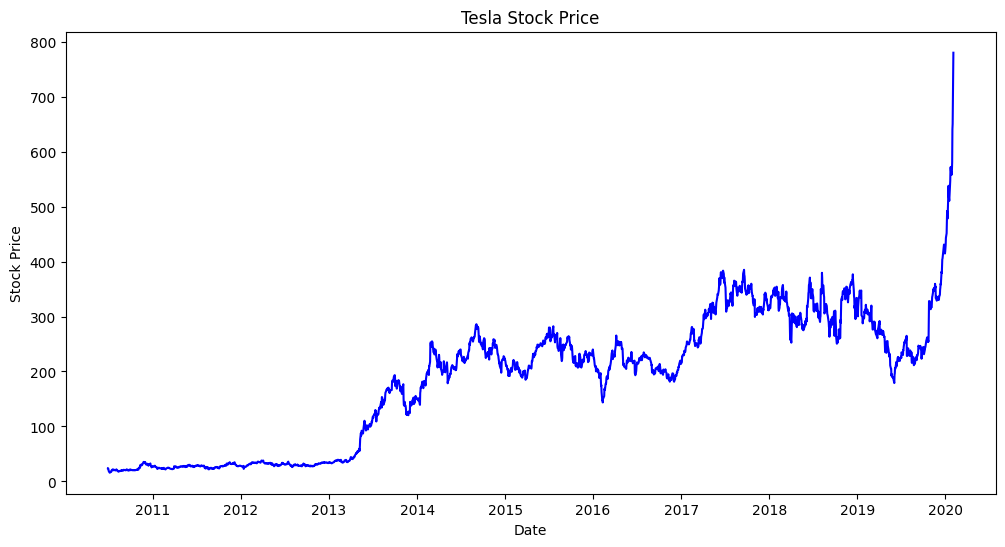

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Tesla Stock Price")
plt.plot(tesla_df['Close'], color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

In [ ]:
tesla_df=tesla_df.values

In [ ]:
tesla_df[:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [ ]:
tesla_df=tesla_df.astype('float32')

In [ ]:
def split_data(dataframe, train_size):
  pos=int(round(len(dataframe)*(1-train_size)))
  train_data=dataframe[:pos]
  test_data=dataframe[pos:]
  return train_data, test_data,pos

In [ ]:
train_data, test_data,pos=split_data(tesla_df,0.2)

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1933, 1)
(483, 1)


In [ ]:
print("train data size: ", len(train_data))
print("test data size: ", len(test_data))

train data size:  1933
test data size:  483


In [ ]:
scaler_train=MinMaxScaler(feature_range=(0,1))

In [ ]:
train_data=scaler_train.fit_transform(train_data)

In [ ]:
scaler_test=MinMaxScaler(feature_range=(0,1))
test_data=scaler_test.fit_transform(test_data)

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1933, 1)
(483, 1)


In [ ]:
train_data[:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [ ]:
test_data[:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [ ]:
def create_features(data, look_back):
  X,Y=[],[]
  for i in range(look_back, len(data)):
    X.append(data[i-look_back:i,0])
    Y.append(data[i,0])
  return np.array(X), np.array(Y)

In [ ]:
look_back=20

In [ ]:
x_train, y_train=create_features(train_data, look_back)
x_test, y_test=create_features(test_data, look_back)

In [ ]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (1913, 20)
y_train shape:  (1913,)
x_test shape:  (463, 20)
y_test shape:  (463,)


In [ ]:
x_train[:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [ ]:
y_train[:5]

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

In [ ]:
x_train=np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test=np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
y_train=np.reshape(y_train, (y_train.shape[0], 1))
y_test=np.reshape(y_test, (y_test.shape[0], 1))

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (1913, 1, 20)
y_train shape:  (1913, 1)
x_test shape:  (463, 1, 20)
y_test shape:  (463, 1)


**Modeling**

In [ ]:
model=Sequential()
model.add(LSTM(units=50,
               activation='relu',
               return_sequences=True,
               input_shape=(x_train.shape[1],look_back)))

model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 50)               │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 1)                │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Optimization
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
callbacks= [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
            ModelCheckpoint(filepath='best_model.keras', monitor='val_loss',
                            save_best_only=True, save_weights_only=False, mode='min', verbose=1)]

In [ ]:
history=model.fit(x=x_train,
                  y=y_train,
                  epochs=100,
                  batch_size=20,
                  validation_data=(x_test, y_test),
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/100
81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 1: val_loss improved from inf to 0.00416, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 2: val_loss improved from 0.00416 to 0.00370, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 3/100
83/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 3: val_loss improved from 0.00370 to 0.00332, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 4/100
75/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 4: val_loss improved from 0.00332 to 0.00322, saving model to best_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 5/100
81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 5: val_loss did not improve from 0.0

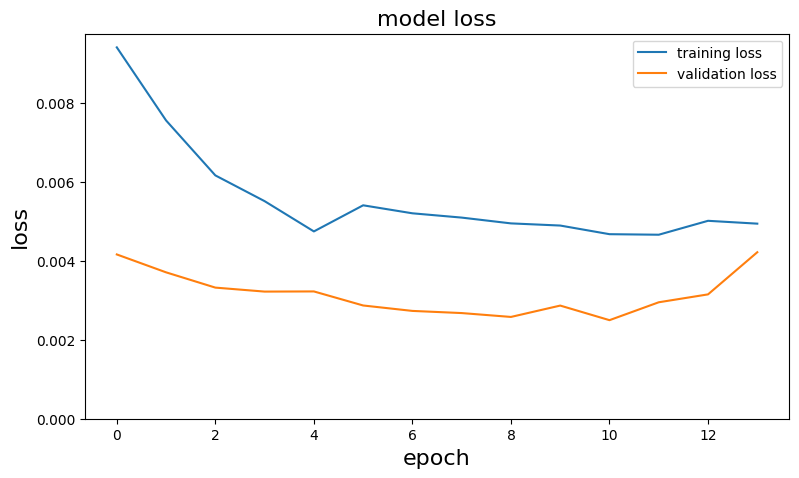

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='upper right')
plt.title('model loss', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.show()

**Evaluation**

In [ ]:
loss=model.evaluate(x_test, y_test,batch_size=20)
print("\n Test loss: %.1f%% " % (loss * 100))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1206713472.0000

 Test loss: 142303398400.0% 


In [ ]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
train_predict_2d = train_predict.reshape(train_predict.shape[0], -1)
test_predict_2d = test_predict.reshape(test_predict.shape[0], -1)

In [ ]:
train_predict = scaler_train.inverse_transform(train_predict_2d)
test_predict = scaler_train.inverse_transform(test_predict_2d)


In [ ]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_train.inverse_transform(y_test)

In [ ]:
train_Rmse=np.sqrt(mean_squared_error(y_train, train_predict))
test_Rmse=np.sqrt(mean_squared_error(y_test, test_predict))

In [ ]:
print("Train RMSE: ", train_Rmse)
print("Test RMSE: ", test_Rmse)

Train RMSE:  26339627.928935368
Test RMSE:  13927376.98220135


In [ ]:
train_prediciton_df= result_df[look_back:pos]
train_prediciton_df['Predicted']=train_predict
train_prediciton_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,40.159821
2010-07-29,20.350000,40.159821
2010-07-30,19.940001,40.159821
2010-08-02,20.920000,40.159821
2010-08-03,21.950001,40.159821


In [ ]:
test_prediciton_df= result_df[pos+look_back:]
test_prediciton_df['Predicted']=test_predict
test_prediciton_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,111.458702
2018-04-04,286.940002,110.049416
2018-04-05,305.720001,109.351532
2018-04-06,299.299988,109.240616
2018-04-09,289.660004,109.318550


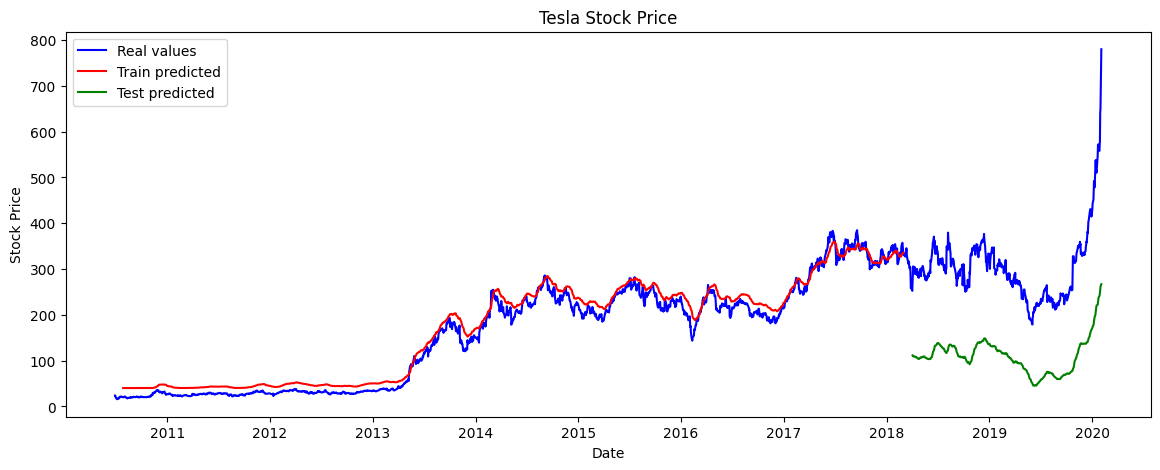

In [102]:
plt.figure(figsize=(14,5))
plt.title("Tesla Stock Price")
plt.plot(result_df['Close'], color="blue", label= 'Real values')
plt.plot(train_prediciton_df['Predicted'], color="red", label= 'Train predicted')
plt.plot(test_prediciton_df['Predicted'], color="green",label= 'Test predicted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()